<div class="alert alert-block alert-success">
    <b><center>CONVOLUTON NEURAL NETWORK</center></b>
    <b><center>K-Fold 개념으로 구현해 보기</center></b>
</div>

# Configure Learning Environment

In [1]:
# !pip install mybatis_mapper2sql
# !pip install git+https://github.com/nockchun/rspy --force

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"

In [3]:
import rspy as rsp
rsp.setSystemWarning(off=True)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact

In [5]:
from sklearn import preprocessing as skpp, model_selection as skms
import tensorflow as tf
from tensorflow.keras import utils, layers, models, losses, preprocessing

In [6]:
# np.set_printoptions(linewidth=200, precision=2)
print("버전: ", tf.__version__)
print("GPU: ", "사용 가능" if tf.test.is_gpu_available() else "사용 불가능")
print("GPU Device: ", tf.config.experimental.get_visible_devices("GPU"))

버전:  2.4.1
GPU:  사용 가능
GPU Device:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Data Loading

* UCI Machine Learning Repository 데이터 이용
* https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset#

In [7]:
import pathlib
dataset_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip"
data_dir = utils.get_file('bike_share.zip', origin=dataset_url, extract=True, cache_subdir='bike_share')
data_dir = pathlib.Path(data_dir)

In [8]:
data_dir.parent.as_posix()

'/home/rsnet/.keras/bike_share'

In [9]:
!ls /home/rsnet/.keras/bike_share

Readme.txt  bike_share.zip  day.csv  hour.csv


In [10]:
df_origin = pd.read_csv(data_dir.parent.as_posix() + "/day.csv")

In [11]:
df_origin.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [12]:
df_origin.shape

(731, 16)

# Data Exploration & Analysis

## 데이터 내용
>* instant : 기록 순서
>* dteday : 기록 날짜
>* season : 계절 [1:봄, 2:여름, 3:가을, 4:겨울]
>* yr : 년
>* mnth : 월 [1-12]
>* holiday : 국경일 유무 [0:무, 1:유]
>* weekday : 요일 [0:일, 1:월, 2:화, 3:수, 4:목, 5:금, 6:토]
>* workingday : 휴무일 유무 [0:일하는 날, 1:쉬는 날]
>* weathersit
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
>* temp : 정규화된 섭씨 온도(℃)
>* atemp : 정규화된 체감 온도. (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50
>* hum : 정규화된 습도.
>* windspeed : 정규화된 풍속.
>* casual : 일반 사용자.
>* registered : 예약 사용자.
>* cnt : 일반 + 예약 사용자. (전체 사용자)

In [13]:
cols = ["season", "mnth", "holiday", "weekday", "workingday", "weathersit", "atemp", "hum", "windspeed"]
@interact(compare=cols)
def exploration(compare):
    fig, ax1 = plt.subplots(figsize=(30, 8))
    ax2 = ax1.twinx()
    
    ax1.plot(df_origin.cnt.values, color="#3186ad", label="cnt")
    ax1.plot(df_origin.casual.values, color="#bebebe", label="casual")
    ax1.plot(df_origin.registered.values, color="#878787", label="registered")
    ax1.set_ylabel("cnt")

    ax2.plot(df_origin[compare].values, color="red", alpha=0.7, label="compare")
    ax2.set_ylabel(compare)
    
    ax1.legend(title="Species", loc="upper left")
    plt.show()

interactive(children=(Dropdown(description='compare', options=('season', 'mnth', 'holiday', 'weekday', 'workin…

# Preprocessing Data

In [14]:
print(list(df_origin.columns))

['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']


In [15]:
df_preproc = df_origin[["holiday", "weekday", "workingday", "weathersit", "temp", "atemp", "hum", "windspeed", "cnt"]]
df_preproc.head()

,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600


## one-hot encoding

In [16]:
onehotWeekday = pd.get_dummies(df_preproc["weekday"], prefix="weekday")
onehotWeathersit = pd.get_dummies(df_preproc["weathersit"], prefix="weathersit")
onehotWeekday.head()

,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0
2,0,1,0,0,0,0,0
3,0,0,1,0,0,0,0
4,0,0,0,1,0,0,0


In [17]:
df_preproc = df_preproc.join(onehotWeekday).join(onehotWeathersit)
df_preproc.head()

,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3
0,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985,0,0,0,0,0,0,1,0,1,0
1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801,1,0,0,0,0,0,0,0,1,0
2,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349,0,1,0,0,0,0,0,1,0,0
3,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562,0,0,1,0,0,0,0,1,0,0
4,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600,0,0,0,1,0,0,0,1,0,0


In [18]:
df_preproc.weathersit.unique()

array([2, 1, 3])

## Scaling Y

In [19]:
scalerCnt = skpp.MinMaxScaler((0, 1))

In [20]:
scaledCnt = scalerCnt.fit_transform(df_preproc["cnt"].values.reshape(len(df_preproc["cnt"]), 1))

In [21]:
df_preproc["cntscl"] = scaledCnt
df_preproc.head()

,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3,cntscl
0,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985,0,0,0,0,0,0,1,0,1,0,0.110792
1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801,1,0,0,0,0,0,0,0,1,0,0.089623
2,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349,0,1,0,0,0,0,0,1,0,0,0.152669
3,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562,0,0,1,0,0,0,0,1,0,0,0.177174
4,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600,0,0,0,1,0,0,0,1,0,0,0.181546


In [22]:
scalerCnt.transform([[985]])

array([[0.11079153]])

In [23]:
scalerCnt.inverse_transform([[0.11079153]])

array([[984.99997876]])

# Prepare Data

In [24]:
preproc_data = df_preproc[["holiday", "workingday", "temp", "atemp", "hum", "windspeed",
     "weekday_0", "weekday_1", "weekday_2", "weekday_3", "weekday_4", "weekday_5", "weekday_6",
     "weathersit_1", "weathersit_2", "weathersit_3", "cntscl"]].values
preproc_label = df_preproc[["cntscl"]].values
preproc_data.shape, preproc_label.shape

((731, 17), (731, 1))

## Splitting

In [25]:
SIZE_VALI  = 50
SIZE_TEST  = 50
SIZE_TRAIN = preproc_data.shape[0] - SIZE_VALI - SIZE_TEST
SIZE_TRAIN

631

In [26]:
train_data = preproc_data[:SIZE_TRAIN]
vali_data = preproc_data[SIZE_TRAIN: -SIZE_VALI]
test_data = preproc_data[-SIZE_VALI:]
train_data.shape, vali_data.shape, test_data.shape

((631, 17), (50, 17), (50, 17))

In [27]:
train_label = preproc_label[:SIZE_TRAIN]
vali_label = preproc_label[SIZE_TRAIN: -SIZE_VALI]
test_label = preproc_label[-SIZE_VALI:]
train_label.shape, vali_label.shape, test_label.shape

((631, 1), (50, 1), (50, 1))

In [28]:
train_data2 = preproc_data[SIZE_VALI:SIZE_TRAIN]
vali_data2 = preproc_data[:SIZE_VALI]

In [29]:
train_label2 = preproc_label[SIZE_VALI:SIZE_TRAIN]
vali_label2 = preproc_label[:SIZE_VALI]

## Windowing

In [31]:
SIZE_FEATURES = train_data.shape[1]
SIZE_TRAIN_DATA = 128 # train_data.shape[0]
TIME_STEP = 5
SIZE_FEATURES, SIZE_TRAIN_DATA

(17, 128)

In [32]:
train_window = preprocessing.sequence.TimeseriesGenerator(
    train_data, train_label, length=TIME_STEP, batch_size=SIZE_TRAIN_DATA
)

In [33]:
vali_window = preprocessing.sequence.TimeseriesGenerator(
    vali_data, vali_label, length=TIME_STEP, batch_size=1
)

In [34]:
test_window = preprocessing.sequence.TimeseriesGenerator(
    test_data, test_label, length=TIME_STEP, batch_size=1
)

In [36]:
train_window2 = preprocessing.sequence.TimeseriesGenerator(
    train_data2, train_label2, length=TIME_STEP, batch_size=SIZE_TRAIN_DATA
)

In [38]:
vali_window2 = preprocessing.sequence.TimeseriesGenerator(
    vali_data2, vali_label2, length=TIME_STEP, batch_size=1
)

In [39]:
len(test_window)

45

In [40]:
x, y = test_window[0]
print(x.tolist())
print(y)

[[[1.0, 0.0, 0.485, 0.475383, 0.741667, 0.173517, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.7187068568798896], [0.0, 1.0, 0.343333, 0.323225, 0.662917, 0.342046, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.4684767602393005], [0.0, 1.0, 0.289167, 0.281563, 0.552083, 0.199625, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.6296594569719283], [0.0, 1.0, 0.321667, 0.324492, 0.620417, 0.152987, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.6239070409572021], [0.0, 1.0, 0.345, 0.347204, 0.524583, 0.171025, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.6530142659917165]]]
[[0.64507593]]


# Generate Model

In [41]:
model = models.Sequential([
    layers.Input([TIME_STEP, SIZE_FEATURES]),
    layers.SimpleRNN(20, return_sequences=True),
    layers.TimeDistributed(layers.Dropout(.2)),
    layers.SimpleRNN(20),
    layers.Dropout(.2),
    layers.Dense(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 5, 20)             760       
_________________________________________________________________
time_distributed (TimeDistri (None, 5, 20)             0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 20)                820       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 1,601
Trainable params: 1,601
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)
)

# Training

In [43]:
history = model.fit_generator(
    train_window,
    epochs=50,
    verbose=1,
    validation_data=vali_window
)

Epoch 1/50
5/5 [==============================] - 1s 83ms/step - loss: 0.9097 - val_loss: 1.0901
Epoch 2/50
5/5 [==============================] - 0s 29ms/step - loss: 0.9678 - val_loss: 0.9388
Epoch 3/50
5/5 [==============================] - 0s 29ms/step - loss: 0.7816 - val_loss: 0.8138
Epoch 4/50
5/5 [==============================] - 0s 31ms/step - loss: 0.6654 - val_loss: 0.7080
Epoch 5/50
5/5 [==============================] - 0s 30ms/step - loss: 0.6259 - val_loss: 0.6154
Epoch 6/50
5/5 [==============================] - 0s 30ms/step - loss: 0.5715 - val_loss: 0.5430
Epoch 7/50
5/5 [==============================] - 0s 29ms/step - loss: 0.5494 - val_loss: 0.4807
Epoch 8/50
5/5 [==============================] - 0s 29ms/step - loss: 0.4992 - val_loss: 0.4288
Epoch 9/50
5/5 [==============================] - 0s 34ms/step - loss: 0.5005 - val_loss: 0.3851
Epoch 10/50
5/5 [==============================] - 0s 35ms/step - loss: 0.5021 - val_loss: 0.3477
Epoch 11/50
5/5 [============

<AxesSubplot:>

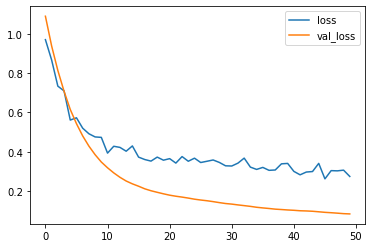

In [44]:
df_history = pd.DataFrame(history.history)
df_history[["loss", "val_loss"]].plot()

In [45]:
history = model.fit_generator(
    train_window2,
    epochs=50,
    verbose=1,
    validation_data=vali_window2
)

Epoch 1/50
5/5 [==============================] - 0s 36ms/step - loss: 0.2978 - val_loss: 0.0748
Epoch 2/50
5/5 [==============================] - 0s 30ms/step - loss: 0.2973 - val_loss: 0.0724
Epoch 3/50
5/5 [==============================] - 0s 29ms/step - loss: 0.2616 - val_loss: 0.0718
Epoch 4/50
5/5 [==============================] - 0s 29ms/step - loss: 0.3023 - val_loss: 0.0701
Epoch 5/50
5/5 [==============================] - 0s 35ms/step - loss: 0.2730 - val_loss: 0.0697
Epoch 6/50
5/5 [==============================] - 0s 29ms/step - loss: 0.2794 - val_loss: 0.0691
Epoch 7/50
5/5 [==============================] - 0s 29ms/step - loss: 0.2772 - val_loss: 0.0694
Epoch 8/50
5/5 [==============================] - 0s 29ms/step - loss: 0.3199 - val_loss: 0.0674
Epoch 9/50
5/5 [==============================] - 0s 29ms/step - loss: 0.3068 - val_loss: 0.0659
Epoch 10/50
5/5 [==============================] - 0s 30ms/step - loss: 0.2892 - val_loss: 0.0661
Epoch 11/50
5/5 [============

<AxesSubplot:>

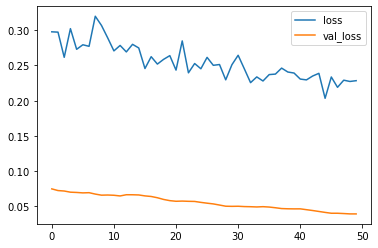

In [46]:
df_history = pd.DataFrame(history.history)
df_history[["loss", "val_loss"]].plot()

# Predict

In [47]:
df_result = pd.DataFrame({'Actual' : [], 'Prediction' : []})

for i in range(len(test_window)):
    x, y = test_window[i]
    yhat = model.predict(x)
    df_result = df_result.append({
        'Actual': scalerCnt.inverse_transform(y)[0][0],
        'Prediction': scalerCnt.inverse_transform(yhat)[0][0]},
        ignore_index=True
    )

In [48]:
df_result['Diff'] = 100 * (df_result['Prediction'] - df_result['Actual']) / df_result['Actual']
df_result.head()

,Actual,Prediction,Diff
0,5629.0,2837.008789,-49.600128
1,4669.0,4917.678711,5.326166
2,5499.0,6027.889648,9.617924
3,5634.0,4032.566162,-28.424456
4,5146.0,5833.921387,13.368080


<AxesSubplot:>

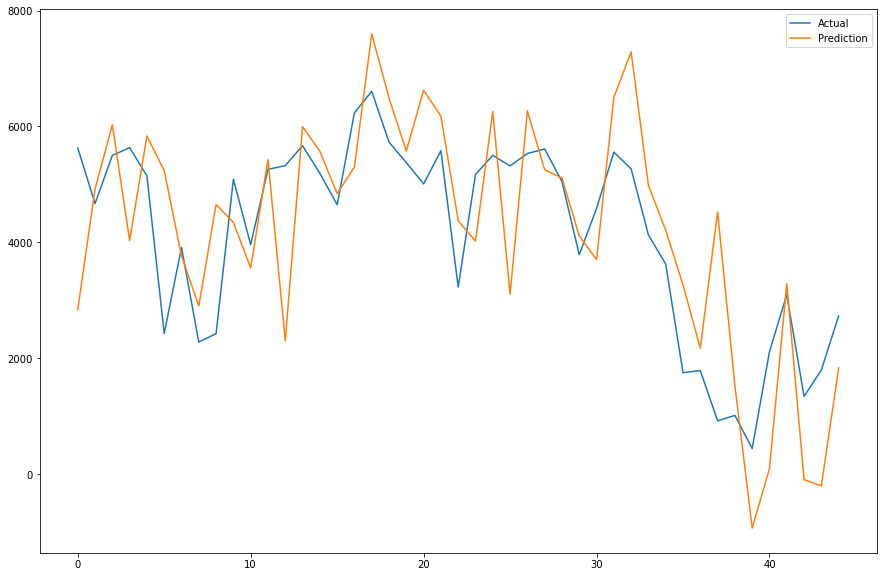

In [49]:
df_result[["Actual", "Prediction"]].plot(figsize=(15, 10))